<a href="https://colab.research.google.com/github/BhoomiMahna/outfit-vibe-rater/blob/experiments/outfit_rater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded= files.upload()


Saving outfits_final.zip to outfits_final.zip


In [2]:
import os
import zipfile
zip_path = "outfits_final.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref: zip_ref.extractall()

print("folders after extraction", os.listdir())

fit_path = os.path.join("outfits", "fit tightness")
print("classes in fit tightness", os.listdir(fit_path))


folders after extraction ['.config', 'outfits', 'outfits_final.zip', 'sample_data']
classes in fit tightness ['tight dress solid single layer (30).jpg', 'tight dress solid.jpg', 'tight dress solid single layer (37).jpg', 'tight dress solid single layer (34).jpg', 'tight dress solid single layer (25).jpg', 'tight dress solid single layer (39).jpg', 'tight dress solid single layer (55).jpg', 'tight dress solid single layer (20).jpg', 'tight dress solid single layer (29).jpg', 'tight dress solid single layer (35).jpg', 'tight dress solid single layer (62).jpg', 'tight dress solid single layer (28).jpg', 'tight dress solid single layer (24).jpg', 'tight dress solid single layer (1).jpg', 'tight dress solid single layer (2).jpg', 'tight dress solid single layer (41).jpg', 'tight dress solid single layer (26).jpg', 'tight dress solid single layer (51).jpg', 'tight dress solid single layer (31).jpg', 'tight dress solid single layer (38).jpg', 'tight dress solid single layer (10).jpg', 'tight 

In [3]:
from pathlib import Path
fit_path= Path("outfits/fit tightness")

for class_folder in fit_path.iterdir():
  if class_folder.is_dir():
    count = sum(1 for f in class_folder.iterdir() if f.is_file())
    print(f"{class_folder.name}: {count} images")

total_images = sum(1 for f in fit_path.rglob("*") if f.is_file())
print("total images in fit tightness", total_images)

tight: 524 images
baggy: 360 images
total images in fit tightness 949


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,models

img_size = (128,128)
batch_size = 32
#fit_path= "outfits/fit tightness"

train_ds = tf.keras.utils.image_dataset_from_directory( fit_path, image_size=img_size, batch_size=batch_size,
                                                       label_mode='categorical', validation_split=0.2, subset='training', seed=42)

class_names = train_ds.class_names
num_classes=len(class_names)
print(f"Class names found: {class_names}")

val_ds = tf.keras.utils.image_dataset_from_directory( fit_path, image_size=img_size, batch_size=batch_size,
                                                       label_mode='categorical', validation_split=0.2, subset='validation', seed=42)


normalization_layer = tf.keras.layers.Rescaling(1./255)

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
], name="data_augmentation"
)

train_ds= train_ds.map(lambda x,y:(normalization_layer(x),y))
val_ds= val_ds.map(lambda x,y:(normalization_layer(x),y))

Found 884 files belonging to 2 classes.
Using 708 files for training.
Class names found: ['baggy', 'tight']
Found 884 files belonging to 2 classes.
Using 176 files for validation.


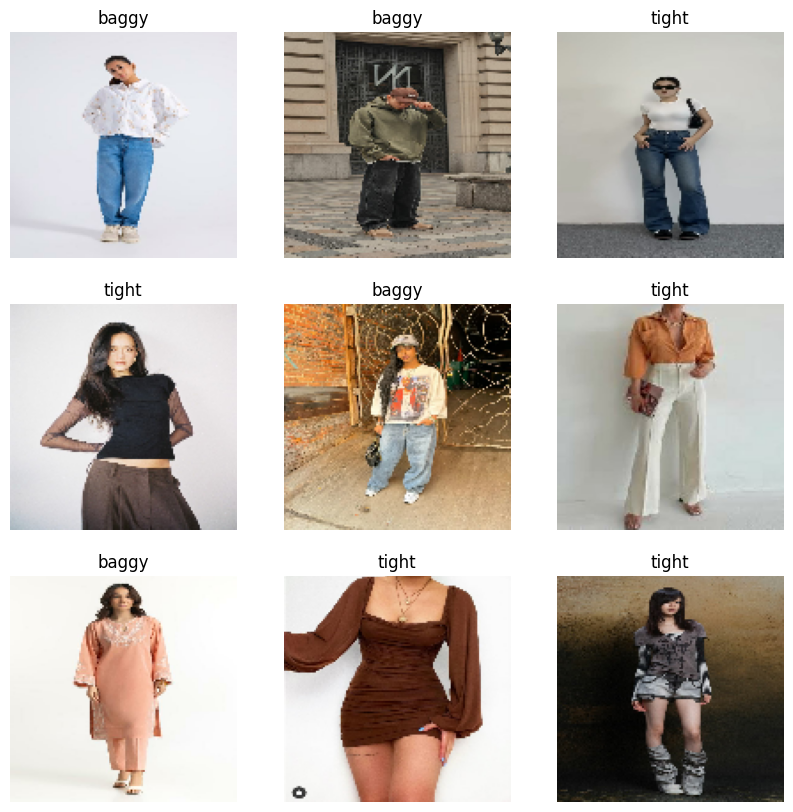

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(10,10))

for images,labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy())
    label_index = np.argmax(labels[i])
    plt.title(class_names[label_index])
    plt.axis("off")

plt.show()

In [7]:
train_ds=train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# --- 1. SETUP: Define Parameters ---
data_dir = 'outfits/fit tightness' # 👈 Make sure this path is correct
img_size = (260, 260) # B2 works well with 260x260 images
batch_size = 32

# --- 2. DATA LOADING ---
print("Loading and preparing datasets...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Found classes: {class_names}")

# --- 3. PREPROCESSING & AUGMENTATION ---
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
], name="data_augmentation")

# Apply performance tuning
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# --- 4. BUILD MODEL WITH EFFICIENTNETV2B2 ---
# Load the more powerful B2 pre-trained base model
base_model = tf.keras.applications.EfficientNetV2B2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model for initial training
base_model.trainable = False

# Create the full model using the Keras Functional API
inputs = layers.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# --- 5. INITIAL TRAINING ---
initial_epochs = 10
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Starting Initial Training ---")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs
)

# --- 6. FINE-TUNING ---
# Unfreeze some layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-50]: # Fine-tune the top 50 layers
    layer.trainable = False

# Re-compile with a very low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Starting Fine-Tuning ---")
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]
)

# --- 7. EVALUATION ---
final_loss, final_accuracy = model.evaluate(val_ds)
print(f"\nFinal Validation Accuracy with EfficientNetV2B2: {final_accuracy:.4f}")

Loading and preparing datasets...
Found 884 files belonging to 2 classes.
Using 708 files for training.
Found 884 files belonging to 2 classes.
Using 176 files for validation.
Found classes: ['baggy', 'tight']
35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Starting Initial Training ---
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.5819 - loss: 0.6981 - val_accuracy: 0.7727 - val_loss: 0.4862
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step - accuracy: 0.7331 - loss: 0.5168 - val_accuracy: 0.8239 - val_loss: 0.4043
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.7930 - loss: 0.4442 - val_accuracy: 0.8239 - val_loss: 0.3799
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.7899 - loss: 0.4367 - val_accuracy: 0.8352 - val_loss: 0.3567
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.8203 - loss: 0.4082 - val_accuracy: 0.8409 - val_loss: 0.3471
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.8052

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# --- 1. SETUP: Define Parameters ---
data_dir = 'outfits/fit tightness' # 👈 Make sure this path is correct
img_size = (224, 224) # ConvNeXt is optimized for 224x224 images
batch_size = 32

# --- 2. DATA LOADING ---
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)
class_names = train_ds.class_names
num_classes = len(class_names)

# --- 3. PREPROCESSING & AUGMENTATION ---
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
], name="data_augmentation")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# --- 4. BUILD MODEL WITH CONVNEXT ---
# Load the ConvNeXtTiny pre-trained base model
base_model = tf.keras.applications.ConvNeXtTiny(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Create the full model
inputs = layers.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
# Use the specific preprocessing function for ConvNeXt
x = tf.keras.applications.convnext.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs, outputs)

# --- 5. INITIAL TRAINING ---
initial_epochs = 10
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("\n--- Starting Initial Training ---")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs
)

# --- 6. FINE-TUNING ---
base_model.trainable = True
for layer in base_model.layers[:-30]: # Fine-tune the top 30 layers
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("\n--- Starting Fine-Tuning ---")
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]
)

# --- 7. EVALUATION ---
final_loss, final_accuracy = model.evaluate(val_ds)
print(f"\nFinal Validation Accuracy with ConvNeXtTiny: {final_accuracy:.4f}")

Found 884 files belonging to 2 classes.
Using 708 files for training.
Found 884 files belonging to 2 classes.
Using 176 files for validation.
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

--- Starting Initial Training ---
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 916s 39s/step - accuracy: 0.6523 - loss: 0.6182 - val_accuracy: 0.7273 - val_loss: 0.5140
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 880s 38s/step - accuracy: 0.7345 - loss: 0.5247 - val_accuracy: 0.8182 - val_loss: 0.4456
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 871s 38s/step - accuracy: 0.7764 - loss: 0.4603 - val_accuracy: 0.8295 - val_loss: 0.4132
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 862s 38s/step - accuracy: 0.8161 - loss: 0.4227 - val_accuracy: 0.8466 - val_loss: 0.3951
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 857s 38s/step - accuracy: 0.8044 - loss: 0.4462 - val_accuracy: 0.8409 - val_loss: 0.3839
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 855s 37s/step - accuracy: 0.8251 - loss: 0.3936 - val_accuracy: 0.8409 - val_loss: 0.3764
Ep

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

# --- 1. SETUP: Define Parameters ---
data_dir = 'outfits/fit tightness' # 👈 Make sure this path is correct
img_size = (160, 160) # EfficientNet works well with slightly larger images
batch_size = 32

# --- 2. DATA LOADING ---
print("Loading and preparing datasets...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Found classes: {class_names}")

# --- 3. PREPROCESSING & AUGMENTATION ---
# Create a data augmentation layer
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
], name="data_augmentation")

# Apply performance tuning to the datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# --- 4. BUILD MODEL WITH TRANSFER LEARNING (EFFICIENTNETV2) ---
# Load the pre-trained base model
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Create the full model
inputs = layers.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet_v2.preprocess_input(x) # Preprocessing layer for EfficientNet
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)


# --- 5. INITIAL TRAINING (Training the new layers) ---
initial_epochs = 10
optimizer_initial = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer_initial,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Starting Initial Training (Training the head) ---")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs
)


# --- 6. FINE-TUNING (Training the top layers of the base model) ---
# Unfreeze the base model and set the top layers as trainable
base_model.trainable = True
for layer in base_model.layers[:-40]: # Freeze all but the top 40 layers
    layer.trainable = False

# Re-compile with a very low learning rate
optimizer_fine_tune = tf.keras.optimizers.Adam(learning_rate=1e-5) # 0.00001
model.compile(
    optimizer=optimizer_fine_tune,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Starting Fine-Tuning ---")
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]
)


# --- 7. EVALUATION & VISUALIZATION ---
# Append the fine-tuning history to the initial history
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Plot the results
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(initial_epochs - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(initial_epochs - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

# Final evaluation
final_loss, final_accuracy = model.evaluate(val_ds)
print(f"\nFinal Validation Accuracy: {final_accuracy:.4f}")

Loading and preparing datasets...
Found 884 files belonging to 2 classes.
Using 708 files for training.
Found 884 files belonging to 2 classes.
Using 176 files for validation.
Found classes: ['baggy', 'tight']
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Starting Initial Training (Training the head) ---
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5762 - loss: 0.6883 - val_accuracy: 0.7159 - val_loss: 0.5421
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7331 - loss: 0.5170 - val_accuracy: 0.7500 - val_loss: 0.4776
Epoch 3/10
 6/23 ━━━━━━━━━━━━━━━━━━━━ 14s 845ms/step - accuracy: 0.7911 - loss: 0.4562

KeyboardInterrupt: 

In [ ]:
# This should show an accuracy of ~85%
loss, accuracy = model.evaluate(val_ds)

print(f"Verified Accuracy of the Restored Model: {accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8082 - loss: 0.3783
Verified Accuracy of the Restored Model: 0.7955


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- Define Your Callbacks ---

# ModelCheckpoint will save the best model found during training
# It will monitor 'val_accuracy' and save the model only when it improves.
checkpoint_cb = ModelCheckpoint(
    "best_fit_tightness_model.h5", # File path to save the model
    save_best_only=True,         # Only save the best model
    monitor="val_accuracy",        # The metric to monitor
    mode="max"                     # We want to maximize this metric
)

# EarlyStopping will stop training if there's no improvement
# It will monitor 'val_loss' and stop if it doesn't improve for 3 epochs.
early_stopping_cb = EarlyStopping(
    patience=3,                  # Number of epochs to wait for improvement
    monitor="val_loss",            # The metric to monitor
    restore_best_weights=True    # Restores model weights from the epoch with the best value
)

# --- Train with the Callbacks ---
# You can now set a higher number of epochs and let the callbacks do the work.
fine_tune_epochs = 50 # Set a high number
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    # Add the callbacks here
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 10/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8395 - loss: 0.3641

23/23 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8386 - loss: 0.3653 - val_accuracy: 0.8068 - val_loss: 0.3851
Epoch 11/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8434 - loss: 0.3668 - val_accuracy: 0.8011 - val_loss: 0.3829
Epoch 12/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8417 - loss: 0.3732 - val_accuracy: 0.7955 - val_loss: 0.3808
Epoch 13/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8310 - loss: 0.3956 - val_accuracy: 0.7955 - val_loss: 0.3840
Epoch 14/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8338 - loss: 0.3786 - val_accuracy: 0.7955 - val_loss: 0.3853
Epoch 15/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8544 - loss: 0.3523 - val_accuracy: 0.7955 - val_loss: 0.3822


In [ ]:
# This should show an accuracy of ~85%
loss, accuracy = model.evaluate(val_ds)

print(f"Verified Accuracy of the Restored Model: {accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8082 - loss: 0.3783
Verified Accuracy of the Restored Model: 0.7955


In [ ]:
import tensorflow as tf

# Load the best model that was saved to your disk
print("Loading the best model from file...")
best_model = tf.keras.models.load_model("best_fit_tightness_model.h5")

# Verify its accuracy
print("\nVerifying the accuracy of the loaded model...")
loss, accuracy = best_model.evaluate(val_ds)

print(f"✅ Verified Accuracy: {accuracy:.4f}")

Loading the best model from file...



Verifying the accuracy of the loaded model...
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8206 - loss: 0.3823
✅ Verified Accuracy: 0.8068


In [ ]:
model = models.Sequential([
    layers.Input(shape=(128,128,3)),

    layers.Conv2D(32,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    #layers.Conv2D(128,(3,3), activation ='relu'),
    #layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics =['accuracy']
)
epochs =10
history = model.fit(
    train_ds, validation_data=val_ds, epochs = epochs
)

loss, accuracy = model.evaluate(val_ds)
print(f"accuracy:{accuracy: .4f}")

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 459ms/step - accuracy: 0.5364 - loss: 3.5479 - val_accuracy: 0.6136 - val_loss: 0.7277
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 450ms/step - accuracy: 0.6274 - loss: 0.6482 - val_accuracy: 0.5682 - val_loss: 0.6652
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 450ms/step - accuracy: 0.7058 - loss: 0.5981 - val_accuracy: 0.5909 - val_loss: 0.6406
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 426ms/step - accuracy: 0.7866 - loss: 0.5068 - val_accuracy: 0.6193 - val_loss: 0.6526
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - accuracy: 0.8526 - loss: 0.4128 - val_accuracy: 0.6591 - val_loss: 0.6806
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 460ms/step - accuracy: 0.9085 - loss: 0.3230 - val_accuracy: 0.6364 - val_loss: 0.6163
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 402ms/step - accuracy: 0.9631 - loss: 0.2242 - val_accuracy: 0.6023 - val_loss: 0.7932
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 442ms/step - accuracy: 0.9695 - loss: 0.1932 - val_accu

In [ ]:
base_model=tf.keras.applications.MobileNetV2(
    input_shape=(128,128,3),
    include_top=False,
    weights ='imagenet'
)
base_model.trainable = False
model=models.Sequential([
    data_augmentation, base_model, layers.GlobalAveragePooling2D(), layers.Dropout(0.3), layers.Dense(num_classes, activation = 'softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

epochs=15
history=model.fit(
    train_ds, validation_data=val_ds, epochs=epochs
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 726ms/step - accuracy: 0.4662 - loss: 1.0886 - val_accuracy: 0.5455 - val_loss: 0.7741
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 642ms/step - accuracy: 0.5700 - loss: 0.8764 - val_accuracy: 0.5909 - val_loss: 0.7506
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 658ms/step - accuracy: 0.5760 - loss: 0.8939 - val_accuracy: 0.5852 - val_loss: 0.7285
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 652ms/step - accuracy: 0.5321 - loss: 0.9343 - val_accuracy: 0.5966 - val_loss: 0.7103
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 653ms/step - accuracy: 0.6019 - loss: 0.8225 - val_accuracy: 0.5966 - val_loss: 0.6955
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 650ms/step - accuracy: 0.6092 - loss: 0.7724 - val_accuracy: 0.6080 - val_loss: 0.6806
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 646ms/step - accuracy: 0.5827 - loss: 0.8325 - val_accuracy: 0.6250 - val_loss: 0.6668
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 651ms/step - accuracy: 0.6074 - loss: 0.7376 - val_accu

In [ ]:
# --- 1. Unfreeze the Base Model ---
# We make the entire base model trainable.
base_model.trainable = True

# --- 2. Freeze all layers except the top few ---
# Let's fine-tune only the top 40 layers of MobileNetV2.
# The earlier layers detect very simple features (lines, colors) that
# don't need changing. The top layers detect more complex, task-specific features.
for layer in base_model.layers[:-40]:
    layer.trainable = False

# --- 3. Re-compile the Model with a VERY Low Learning Rate ---
# This is crucial to avoid destroying the pre-trained weights.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5) # 0.00001
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary() # Notice more trainable parameters now

# --- 4. Continue Training (Fine-Tuning) ---
# We train for a few more epochs to fine-tune the unfrozen layers.
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs

# Continue training from where we left off
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] # Start from the last epoch of previous training
)



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 1,684,098 (6.42 MB)

 Non-trainable params: 576,448 (2.20 MB)

Epoch 15/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 950ms/step - accuracy: 0.6028 - loss: 0.7338 - val_accuracy: 0.7102 - val_loss: 0.5608
Epoch 16/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 884ms/step - accuracy: 0.7093 - loss: 0.6130 - val_accuracy: 0.7216 - val_loss: 0.5503
Epoch 17/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 822ms/step - accuracy: 0.6451 - loss: 0.6644 - val_accuracy: 0.7386 - val_loss: 0.5365
Epoch 18/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 879ms/step - accuracy: 0.6680 - loss: 0.6301 - val_accuracy: 0.7443 - val_loss: 0.5293
Epoch 19/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 818ms/step - accuracy: 0.6984 - loss: 0.6185 - val_accuracy: 0.7500 - val_loss: 0.5252
Epoch 20/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 890ms/step - accuracy: 0.7234 - loss: 0.5491 - val_accuracy: 0.7557 - val_loss: 0.5133
Epoch 21/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 851ms/step - accuracy: 0.7110 - loss: 0.5946 - val_accuracy: 0.7614 - val_loss: 0.5160
Epoch 22/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 884ms/step - accuracy: 0.7111 - loss: 0.5599 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


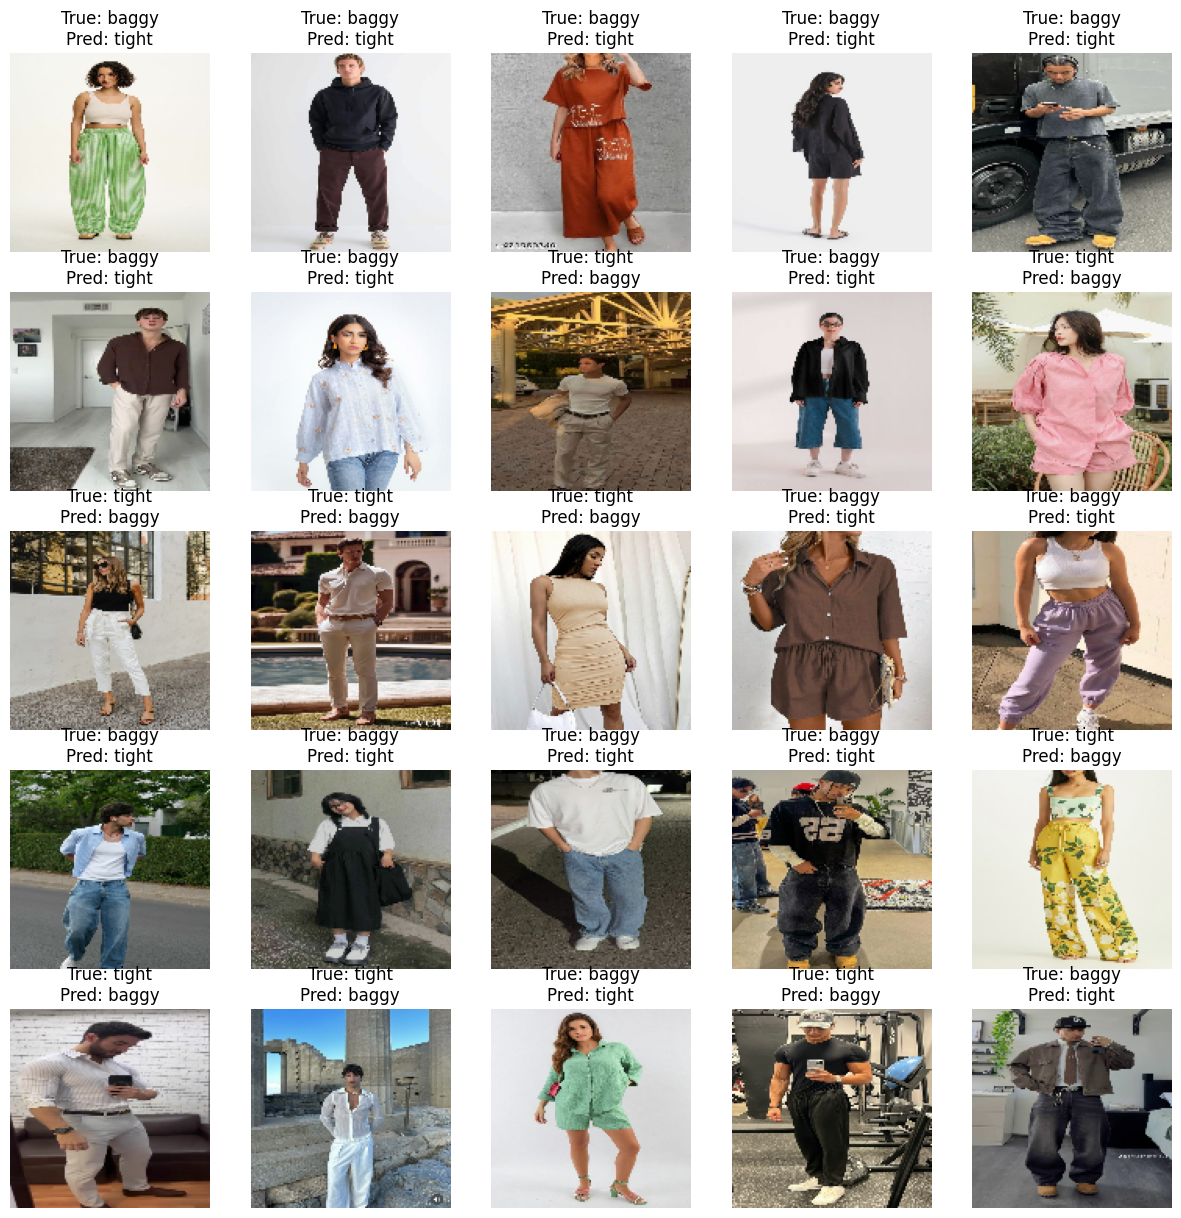

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a new figure to display the mistakes
plt.figure(figsize=(15, 15))
plot_index = 1

# Iterate through the validation dataset
for images, labels in val_ds:
    # Get model predictions
    predictions = model.predict(images)

    # Loop through each image in the batch
    for i in range(len(images)):
        # Get the predicted class index (0 or 1)
        predicted_class = np.argmax(predictions[i])
        # Get the true class index
        true_class = np.argmax(labels[i])

        # If the prediction is wrong, plot the image
        if predicted_class != true_class:
            if plot_index <= 25: # Limit to the first 25 mistakes
                plt.subplot(5, 5, plot_index)
                plt.imshow(images[i].numpy())
                title = f"True: {class_names[true_class]}\nPred: {class_names[predicted_class]}"
                plt.title(title)
                plt.axis('off')
                plot_index += 1
plt.show()
